## Setup

### GPU Usage

In [1]:
!nvidia-smi
!nvidia-smi -L

Fri Jun  7 12:49:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:02:00.0 Off |                    0 |
|  0%   40C    P0              73W / 300W |  10954MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from network_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, AutoConfig 
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
if constants.LOAD_MODEL:
    device = torch.device("cuda")
    login(token = TOKEN)
    attn_implementation="eager" # GEMMA_ATTENTION_CLASSES = {"eager": GemmaAttention, "flash_attention_2": GemmaFlashAttention2, "sdpa": GemmaSdpaAttention,}


    tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
    model = AutoModelForCausalLM.from_pretrained(
        constants.MODEL_NAME, 
        cache_dir=constants.CACHE_DIR_BITBUCKET, 
        device_map='auto', 
        attn_implementation=attn_implementation, # Make sure to use the adequate attention layer in order to 
    )
    model.eval()
    print("Loaded Model Name: ", model.config.name_or_path)
    print("Model: ", model)
    print("Attention Layers Implementation: ", model.config._attn_implementation)
    print(f"Number of layers: {constants.NUM_LAYERS}")
    print(f"Number of attention heads per layer: {constants.NUM_HEADS_PER_LAYER}")

### Simple Prompt

In [4]:
if constants.LOAD_MODEL:
    prompt = "What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. "
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_new_tokens=20,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            attention_mask=inputs['attention_mask']  # Provide attention mask for reliable results
        )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)

### Autoregresive Sampling

In [5]:
if constants.LOAD_MODEL:
    # prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
    prompt = "What is the sum of 457 and 674?"# Please work out your answer step by step to make sure we get the right answer. "
    # prompt = "How much is 2 multiplied by 8?"
    # prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
    num_tokens_to_generate = 100
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
        temperature=0.3, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
    print(attention_params[constants.ATTENTION_MEASURE].shape)
    print(generated_text)

## Raw Attention and Time Series Generation

In [6]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 0.3
generated_text, attention_params, time_series = {}, {}, {}

if constants.GENERATE_RAW_ATTENTION_AND_TIME_SERIES:
    print("Generating Raw Attention and Time Series")
    for cognitive_task in constants.PROMPT_CATEGORIES:
        print("Generating Raw Attention and Time Series for Cognitive Task: ", cognitive_task)
        prompt = constants.PROMPTS[cognitive_task][0]
        
        generated_text[cognitive_task], attention_params[cognitive_task] = generate_text_with_attention(model, tokenizer, 
            num_tokens_to_generate, device, prompt=prompt, temperature=temperature, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
        save_raw_attention(generated_text[cognitive_task], attention_params[cognitive_task],  base_save_path=constants.RAW_ATTENTION_DIR+cognitive_task+"/")
        
        time_series[cognitive_task] = compute_attention_metrics_norms(attention_params[cognitive_task], constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
        save_time_series(time_series[cognitive_task], base_save_path=constants.TIME_SERIES_DIR+cognitive_task+".pt")
        plot_attention_metrics_norms_over_time(time_series[cognitive_task], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, 
            smoothing_window=10, save=True, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/")
        print(f'Generated Text for {cognitive_task}: {generated_text[cognitive_task]}')
else:
    print("Loading Raw Attention and Time Series")
    for cognitive_task in constants.PROMPT_CATEGORIES:
        print("Loading Cognitive Task: ", cognitive_task)
        generated_text[cognitive_task], attention_params[cognitive_task] = load_raw_attention(base_save_path=constants.RAW_ATTENTION_DIR+cognitive_task+"/")
        time_series[cognitive_task] = load_time_series(base_load_path=constants.TIME_SERIES_DIR+cognitive_task+".pt")
        plot_attention_metrics_norms_over_time(time_series[cognitive_task], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, 
            save=True, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/")

Loading Raw Attention and Time Series
Loading Cognitive Task:  syntax_and_grammar_recognition
Loading Cognitive Task:  part_of_speech_tagging
Loading Cognitive Task:  basic_numerical_reasoning
Loading Cognitive Task:  basic_common_sense_reasoning
Loading Cognitive Task:  abstract_reasoning_and_creative_thinking
Loading Cognitive Task:  emotional_intelligence_and_social_cognition


## $\Phi$ ID Computations

### Compute and Save PhiID Matrices given time_series Dictionary

In [7]:
if constants.COMPUTE_PID:
    print("\n--- Computing PhiID for all tasks ---")
    all_matrices, synergy_matrices, redundancy_matrices = {}, {}, {}
    for cognitive_task in constants.PROMPT_CATEGORIES:
        print("\n--- Computing PhiID for task ", cognitive_task, " ---")
        all_matrices[cognitive_task], synergy_matrices[cognitive_task], redundancy_matrices[cognitive_task] = compute_PhiID(time_series[cognitive_task],
                    save=True, kind="gaussian", base_save_path=constants.MATRICES_DIR+cognitive_task+'.pt')
    # Compute and Save Average Prompt Matrices
    print("\n--- Computing Average Prompt Matrices ---")
    all_matrices, synergy_matrices, redundancy_matrices = average_synergy_redundancies_matrices_cognitive_tasks(all_matrices, synergy_matrices, redundancy_matrices)
    save_matrices(all_matrices, synergy_matrices, redundancy_matrices, base_save_path=constants.MATRICES_DIR + 'average_prompts' + '.pt')

### Synergy and Redundancy Plots for All Prompt Categories

In [8]:
for prompt_category_name in constants.PROMPT_CATEGORIES:
    print("Plotting Prompt Category: ", prompt_category_name,)
    
    global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
    plot_all_PhiID(global_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

    base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/'
    averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
    plot_averages_per_head(averages, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
    # plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
    gradient_ranks = compute_gradient_rank(averages)
    plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
    ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

Plotting Prompt Category:  syntax_and_grammar_recognition
Plotting Prompt Category:  part_of_speech_tagging
Plotting Prompt Category:  basic_numerical_reasoning
Plotting Prompt Category:  basic_common_sense_reasoning
Plotting Prompt Category:  abstract_reasoning_and_creative_thinking
Plotting Prompt Category:  emotional_intelligence_and_social_cognition


### Synergy and Redundancy Plots for Concrete Prompt Category

In [9]:
prompt_category_name = 'average_prompts'
print("\n--- Plotting Prompt Category: ", prompt_category_name, " ---")

# global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_all_PhiID(global_matrices, save=True, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
# plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=True, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)


--- Plotting Prompt Category:  average_prompts  ---


## Different Heads for Different Cognitive Tasks

### Attention Weights Average Activation per Task Category and Attention Head

In [10]:
base_plot_path = constants.PLOTS_HEAD_ACTIVATIONS_COGNITIVE_TASKS
if constants.GENERATE_ATTENTION_WEIGHTS: 
    print("Generating Attention Weights")
    attention_weights_prompts, generated_text = solve_prompts(constants.PROMPTS, model, tokenizer, device, num_tokens_to_generate=64,temperature=0.7, attention_measure=constants.ATTENTION_MEASURE)
    save_attention_weights(attention_weights_prompts, generated_text)
else:
    print("Loading Attention Weights")
    attention_weights_prompts =  load_attention_weights()

print("Plotting Attention Weights")
summary_stats_prompts = plot_categories_comparison(attention_weights_prompts, save=True, base_plot_path=base_plot_path, split_half=False, split_third=False)
plot_all_heatmaps(attention_weights_prompts, save=True, base_plot_path=base_plot_path)

Loading Attention Weights
Plotting Attention Weights


### LDA Analysis of the Attention Weights

In [11]:
perform_lda_analysis(attention_weights_prompts, save=True, base_plot_path=base_plot_path)

## Synergy Redundancy and Task Correlations

### Categories Correlation

In [12]:
results = plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], 
                save=True, reorder=False, per_layer=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)

### Average Rank of Most Significantly Activated Heads by Category

In [13]:
plot_rank_most_activated_heads_per_task(summary_stats_prompts, gradient_ranks, top_ns=[1,3,5,10,30, 50], save=True)

### Top Synergistic and Top Redundant Heads

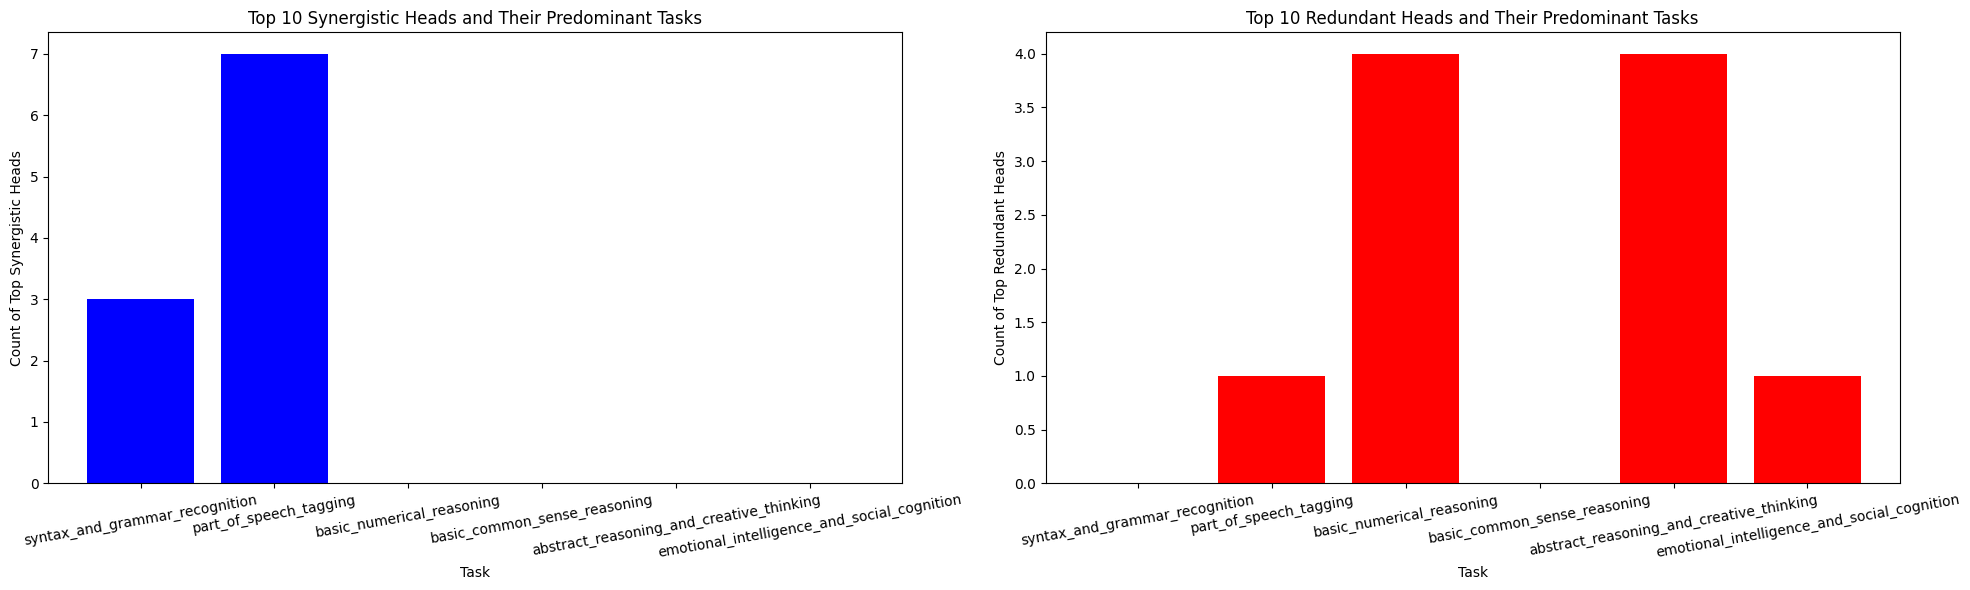

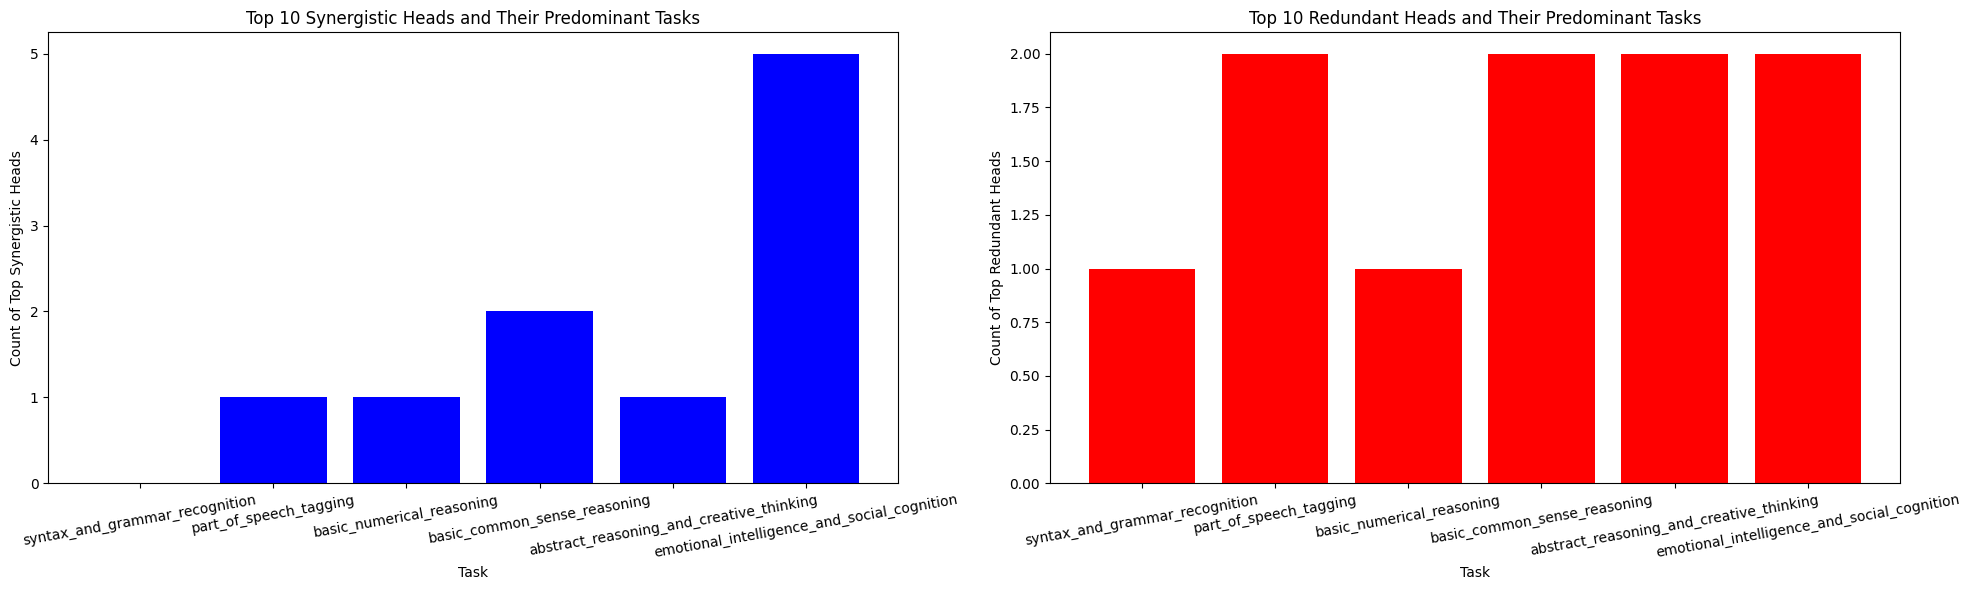

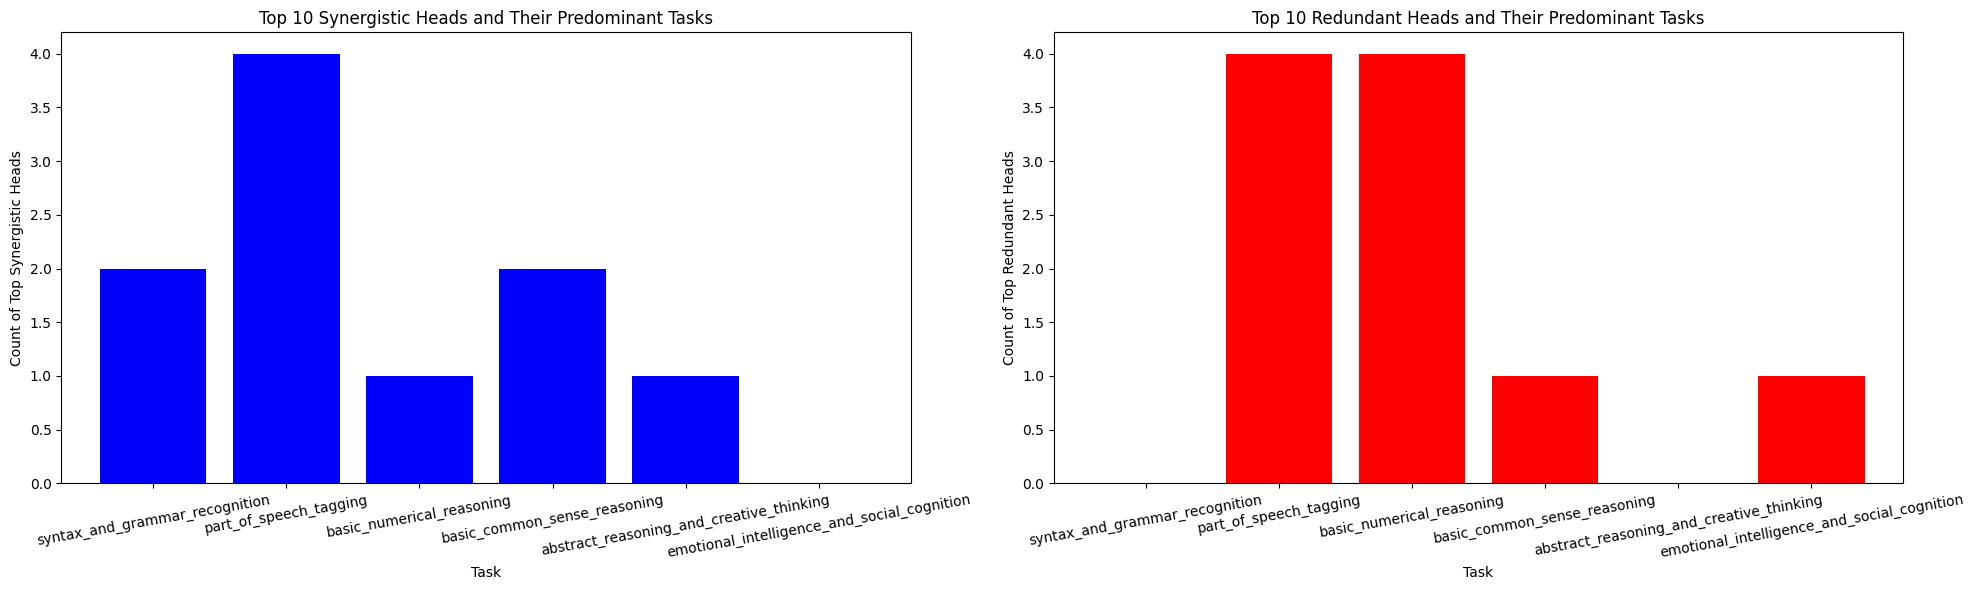

In [14]:
plot_most_syn_red_tasks(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Head Activation per Task

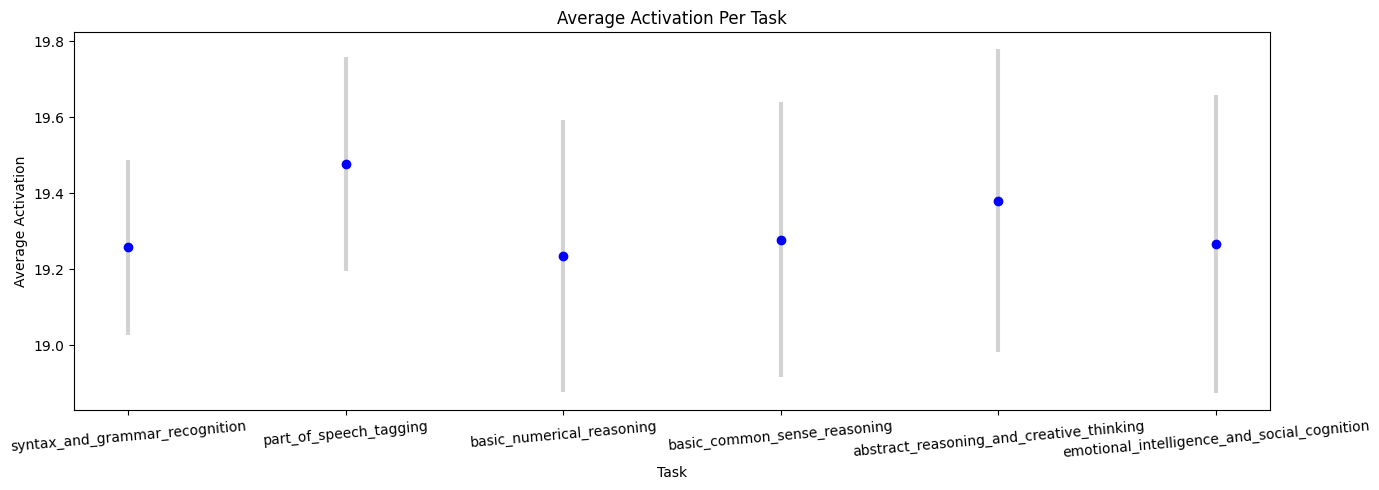

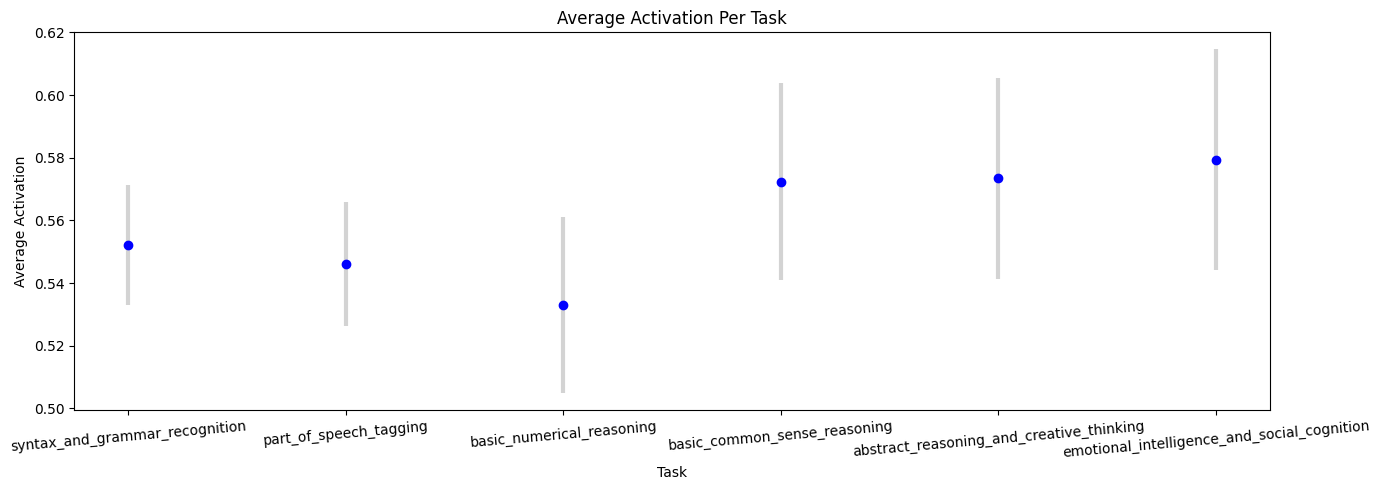

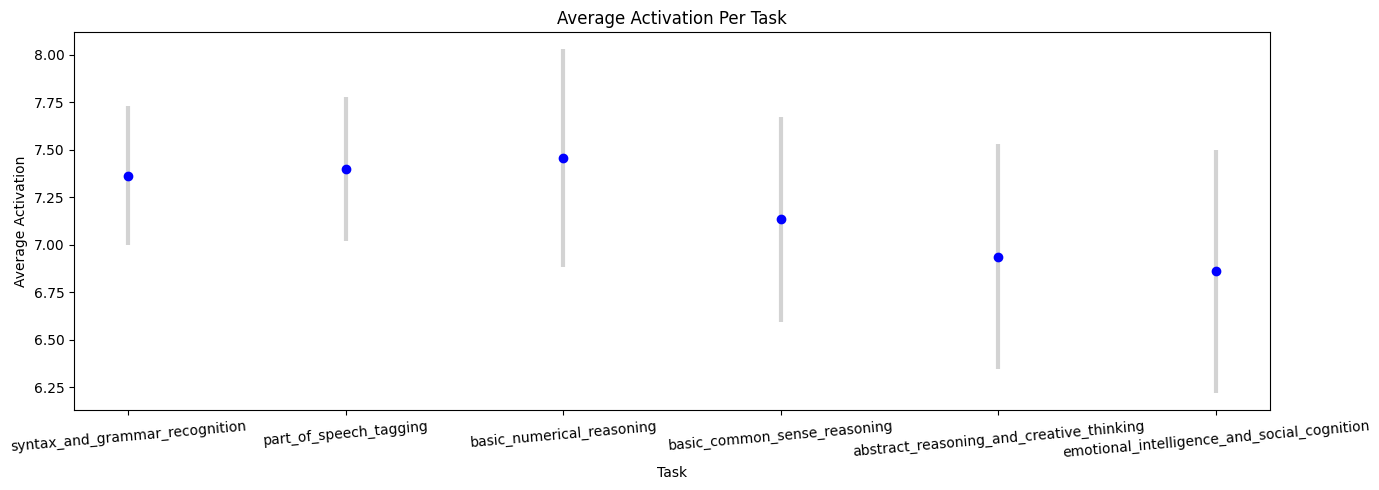

In [15]:
plot_average_head_activation_per_task(summary_stats_prompts)

## Graph Theoretical Properties Synergy and Redundancy Matrices

In [ ]:
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
efficiency_results, modularity_results = compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=False)
print(efficiency_results)
print(modularity_results)